In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from itertools import product
# For seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# Import additional functions needed
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# to measure model performance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
# To model with sklearn
from sklearn.linear_model import Lasso, Ridge, LinearRegression, HuberRegressor, ElasticNet
from sklearn.utils.validation import check_is_fitted


In [2]:
#reading the csv file that we exported after exploration for the deployment of ML models
df_windspeed=pd.read_csv('windspeed_data.csv')
df_windspeed.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df_windspeed['datetime'] = pd.to_datetime(df_windspeed['datetime'])
df_windspeed.set_index('datetime', inplace=True)
df_windspeed

,windspeed
datetime,
2010-01-01 00:00:00,19.4
2010-01-01 01:00:00,21.8
2010-01-01 02:00:00,17.7
2010-01-01 03:00:00,18.0
2010-01-01 04:00:00,17.4
...,...
2024-01-06 07:00:00,9.6
2024-01-06 08:00:00,8.9
2024-01-06 09:00:00,9.6


## Basline Models

In [3]:
#Split the data in train, validation and test (2010-2020=Train, 2021-2022=Valdation, 2023=Test)
#For dummy/Base line I am using the monthly data as it becomes easy to visualize
# Split the dataset
train = df_windspeed['2010':'2020']  
validation = df_windspeed.loc['2021':'2022'] 
test = df_windspeed.loc['2023']  
print('Start and end of training set:\t\t', train.index.min(), train.index.max())
print('Start and end of validation set:\t', validation.index.min(), validation.index.max())
print('Start and end of test set:\t\t', test.index.min(), test.index.max())


Start and end of training set:		 2010-01-01 00:00:00 2020-12-31 23:00:00
Start and end of validation set:	 2021-01-01 00:00:00 2022-12-31 23:00:00
Start and end of test set:		 2023-01-01 00:00:00 2023-12-31 23:00:00


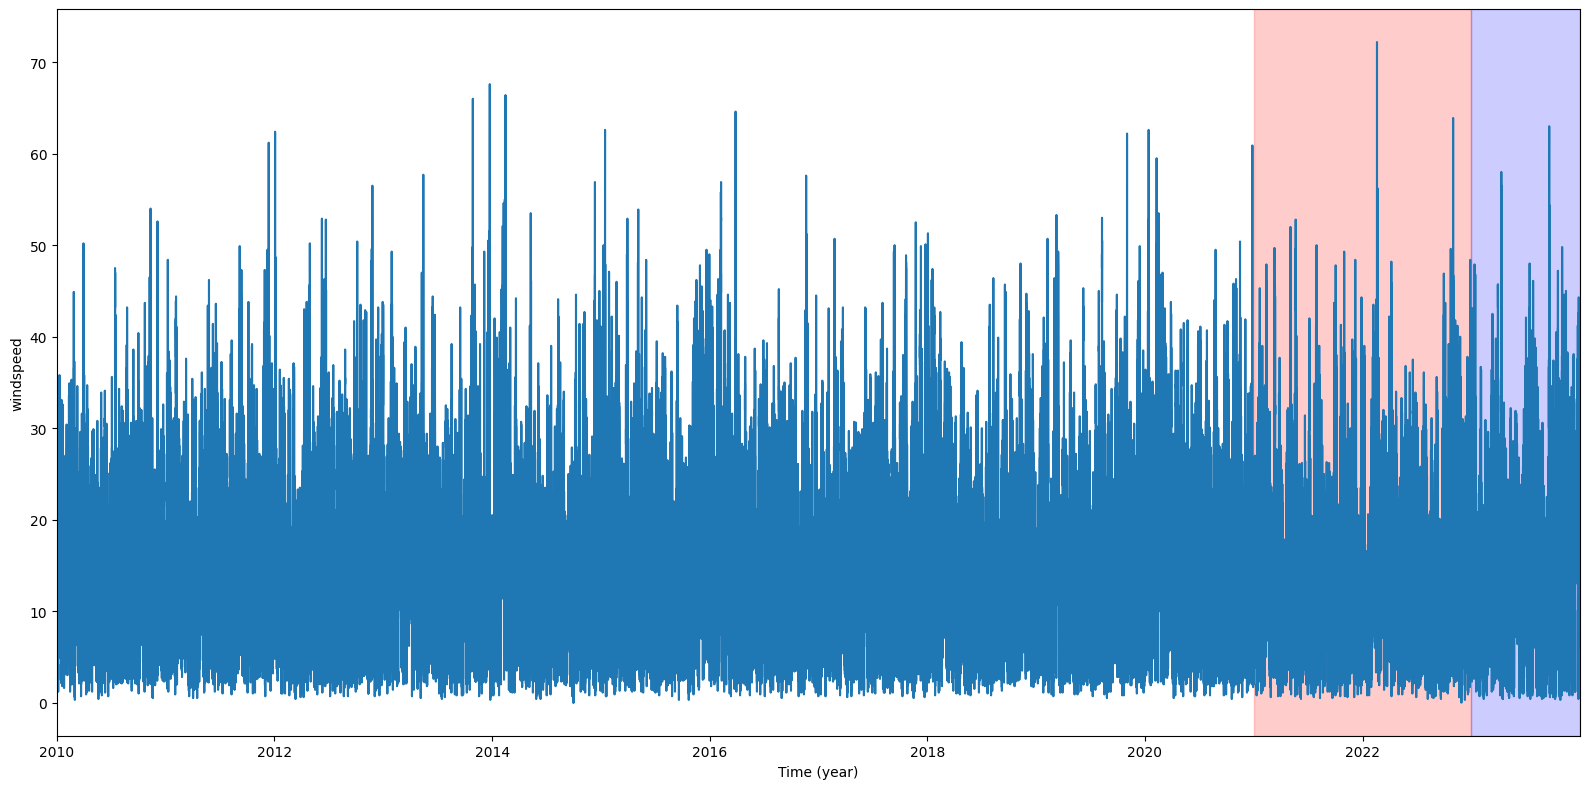

In [4]:
#plot the train, valdation and test
fig, ax = plt.subplots(figsize=(16,8))

# Plot windspeed data
ax.plot(df_windspeed.index, df_windspeed['windspeed'])

# Highlight validation and test sets
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set

# Set labels and limits
ax.set_xlabel('Time (year)')
ax.set_ylabel('windspeed')
ax.set_xlim(train.index.min(), test.index.max())

plt.tight_layout()
plt.show()


In [5]:
def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f' % mean_absolute_error(label, forecast))
    print('MAPE = %.2f%%' % (100*mean_absolute_percentage_error(label, forecast)))
    print('R2 = %.2f' % r2_score(label, forecast))

MAE = 9.24
MAPE = 311036275634703.88%
R2 = -0.90


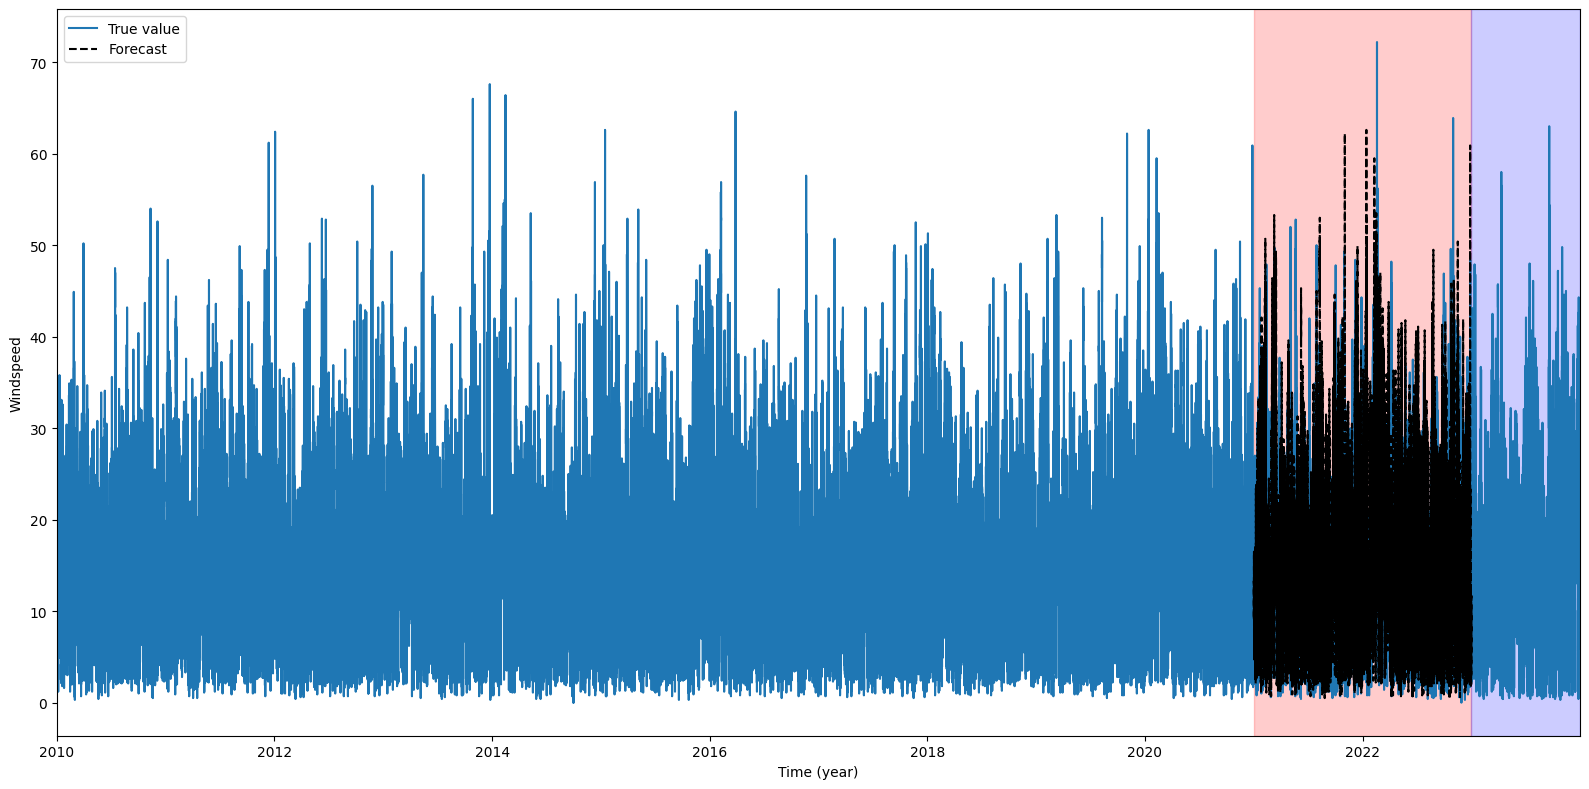

In [6]:
#The dummy basline is used where the data from the 2019-2022 is used to forcast
validation['baseline_last_period'] = train.loc['2019':'2020']['windspeed'].values[:len(validation)]

measure_forecast_error(validation['windspeed'], validation['baseline_last_period'])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_windspeed.index, df_windspeed['windspeed'], label='True value')
ax.plot(validation.index, validation['baseline_last_period'], '--', color='k', label='Forecast')
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Windspeed')
_=ax.set_xlim(train.index.min(), test.index.max())
plt.legend(loc='best')
plt.tight_layout()


In [7]:
#the dummy from previous data does not gives good results here i tried the mean of past data however no much improvement was there
validation['baseline_mean'] = train['windspeed'].mean()

measure_forecast_error(validation['windspeed'], validation['baseline_mean'])


MAE = 6.89
MAPE = 411907189534038.94%
R2 = -0.01


## Machine Learning

In [8]:
# Prepare data for ML:

df_windspeed_ML = df_windspeed['windspeed'].copy().to_frame() 
# We want to forecast on horly basis. Let's create windows of 24 Hours we can tune that parameter later
forecast_horizon = 1  # next Hour
window_size = 24  # use one hour of data
for lag in range(window_size-1):
    df_windspeed_ML['Windspeed_lag%d' % (lag+1)] = df_windspeed_ML['windspeed'].shift(lag+1)
df_windspeed_ML['y'] = df_windspeed_ML['windspeed'].shift(-forecast_horizon)  # our target
df_windspeed_ML.head()

,windspeed,Windspeed_lag1,Windspeed_lag2,Windspeed_lag3,Windspeed_lag4,Windspeed_lag5,Windspeed_lag6,Windspeed_lag7,Windspeed_lag8,Windspeed_lag9,...,Windspeed_lag15,Windspeed_lag16,Windspeed_lag17,Windspeed_lag18,Windspeed_lag19,Windspeed_lag20,Windspeed_lag21,Windspeed_lag22,Windspeed_lag23,y
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,19.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.8
2010-01-01 01:00:00,21.8,19.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.7
2010-01-01 02:00:00,17.7,21.8,19.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
2010-01-01 03:00:00,18.0,17.7,21.8,19.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.4
2010-01-01 04:00:00,17.4,18.0,17.7,21.8,19.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.9


In [9]:
# We have missing values in the first rows because of the lags. Let's drop those
df_windspeed_ML.dropna(inplace=True)
df_windspeed_ML

,windspeed,Windspeed_lag1,Windspeed_lag2,Windspeed_lag3,Windspeed_lag4,Windspeed_lag5,Windspeed_lag6,Windspeed_lag7,Windspeed_lag8,Windspeed_lag9,...,Windspeed_lag15,Windspeed_lag16,Windspeed_lag17,Windspeed_lag18,Windspeed_lag19,Windspeed_lag20,Windspeed_lag21,Windspeed_lag22,Windspeed_lag23,y
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 23:00:00,4.8,8.9,10.5,7.6,10.5,10.3,8.5,9.9,14.9,18.5,...,14.3,12.6,15.4,15.9,17.4,18.0,17.7,21.8,19.4,3.3
2010-01-02 00:00:00,3.3,4.8,8.9,10.5,7.6,10.5,10.3,8.5,9.9,14.9,...,14.2,14.3,12.6,15.4,15.9,17.4,18.0,17.7,21.8,5.9
2010-01-02 01:00:00,5.9,3.3,4.8,8.9,10.5,7.6,10.5,10.3,8.5,9.9,...,14.0,14.2,14.3,12.6,15.4,15.9,17.4,18.0,17.7,4.9
2010-01-02 02:00:00,4.9,5.9,3.3,4.8,8.9,10.5,7.6,10.5,10.3,8.5,...,18.6,14.0,14.2,14.3,12.6,15.4,15.9,17.4,18.0,4.9
2010-01-02 03:00:00,4.9,4.9,5.9,3.3,4.8,8.9,10.5,7.6,10.5,10.3,...,20.1,18.6,14.0,14.2,14.3,12.6,15.4,15.9,17.4,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-06 06:00:00,9.9,8.4,8.8,8.5,5.6,5.0,7.7,8.0,10.8,9.6,...,11.6,14.8,16.8,18.4,16.4,20.1,14.9,18.0,17.7,9.6
2024-01-06 07:00:00,9.6,9.9,8.4,8.8,8.5,5.6,5.0,7.7,8.0,10.8,...,12.8,11.6,14.8,16.8,18.4,16.4,20.1,14.9,18.0,8.9
2024-01-06 08:00:00,8.9,9.6,9.9,8.4,8.8,8.5,5.6,5.0,7.7,8.0,...,14.2,12.8,11.6,14.8,16.8,18.4,16.4,20.1,14.9,9.6


In [10]:
# Split the dataset using the df_windspeed_ML that we created using the time lags
features = list(df_windspeed_ML.columns)[:-1]
train = df_windspeed_ML['2010':'2020']  
validation = df_windspeed_ML.loc['2021':'2022'] 
test = df_windspeed_ML.loc['2024']


In [11]:
# Let's have a look at a family of regressors and pick one of them. We're choosing based on the validation set
models = [('Linear Regression', LinearRegression()), ('ElasticNet', ElasticNet()), ('Ridge', Ridge()), ('Lasso', Lasso()), ('Huber', HuberRegressor())]
for mname, model in models:
    model.fit(train[features], train['y'])
    validation['y_pred_%s' % mname] = model.predict(validation[features])
    print(mname)
    measure_forecast_error(validation['y'], validation['y_pred_%s' % mname])

Linear Regression
MAE = 2.54
MAPE = 202172805926225.66%
R2 = 0.84
ElasticNet
MAE = 2.55
MAPE = 205184009994415.22%
R2 = 0.84
Ridge
MAE = 2.54
MAPE = 202172802239404.47%
R2 = 0.84
Lasso
MAE = 2.56
MAPE = 206529330788354.19%
R2 = 0.83
Huber
MAE = 2.54
MAPE = 193550721087580.88%
R2 = 0.83


## Neural Networks (Mltilayer Perceptron)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(100, activation='relu', input_shape=(len(features),)),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(train[features], train['y'], validation_data=(validation[features], validation['y']), epochs=50, batch_size=32)

# Evaluate the model
validation['y_pred_MLP'] = model.predict(validation[features])
measure_forecast_error(validation['y'], validation['y_pred_MLP'])


Epoch 1/50
3013/3013 [==============================] - 8s 2ms/step - loss: 13.7683 - val_loss: 12.7747
Epoch 2/50
3013/3013 [==============================] - 10s 3ms/step - loss: 12.3838 - val_loss: 12.9761
Epoch 3/50
3013/3013 [==============================] - 10s 3ms/step - loss: 12.2658 - val_loss: 12.1535
Epoch 4/50
3013/3013 [==============================] - 10s 3ms/step - loss: 12.1712 - val_loss: 12.1048
Epoch 5/50
3013/3013 [==============================] - 8s 3ms/step - loss: 12.0913 - val_loss: 12.1290
Epoch 6/50
3013/3013 [==============================] - 7s 2ms/step - loss: 12.0699 - val_loss: 12.1918
Epoch 7/50
3013/3013 [==============================] - 7s 2ms/step - loss: 12.0819 - val_loss: 12.1580
Epoch 8/50
3013/3013 [==============================] - 7s 2ms/step - loss: 12.0302 - val_loss: 12.2081
Epoch 9/50
3013/3013 [==============================] - 6s 2ms/step - loss: 11.9795 - val_loss: 12.1827
Epoch 10/50
3013/3013 [==============================] - 6s 2

In [13]:
test['y_pred_MLP'] = model.predict(test[features])

5/5 [==============================] - 0s 2ms/step


In [14]:

df_powercal_24H = test.loc["2024-01-05":"2024-01-06", test.columns[-2:]] #Last 24 Hours of data for power cal (Actual vs Pred pwer)
df_powercal_24H

,y,y_pred_MLP
datetime,,
2024-01-05 00:00:00,28.0,23.755999
2024-01-05 01:00:00,28.7,27.441980
2024-01-05 02:00:00,31.8,28.072094
2024-01-05 03:00:00,22.9,30.981529
2024-01-05 04:00:00,23.0,20.333801
2024-01-05 05:00:00,21.8,21.587736
2024-01-05 06:00:00,17.7,20.048281
2024-01-05 07:00:00,18.0,15.925953
2024-01-05 08:00:00,14.9,16.705627


In [15]:

# Define the given values
density = 1.225  # density in kg/m^3
radius = 140  # radius in meters
area = np.pi * (radius ** 2)  # area in square meters

# actual and pridicted wind speed (velocity) from the first column of the DataFrame 
actual_velocity = df_powercal_24H.iloc[:, 0]  
pridicted_velocity= df_powercal_24H.iloc[:, 1]

# Calculate power using the formula
actual_power = 0.5 * density * area * (actual_velocity ** 3)//1000
pridicted_power= 0.5 * density * area * (pridicted_velocity ** 3)//1000

# Add the calculated power as a new column to the DataFrame
df_powercal_24H['power_actual(KW)'] = actual_power 
df_powercal_24H['power_pridicted(KW)'] = pridicted_power

df_powercal_24H

,y,y_pred_MLP,power_actual(KW),power_pridicted(KW)
datetime,,,,
2024-01-05 00:00:00,28.0,23.755999,827915.0,505628.0
2024-01-05 01:00:00,28.7,27.441980,891574.0,779396.0
2024-01-05 02:00:00,31.8,28.072094,1212811.0,834327.0
2024-01-05 03:00:00,22.9,30.981529,452916.0,1121555.0
2024-01-05 04:00:00,23.0,20.333801,458876.0,317079.0
2024-01-05 05:00:00,21.8,21.587736,390734.0,379431.0
2024-01-05 06:00:00,17.7,20.048281,209137.0,303908.0
2024-01-05 07:00:00,18.0,15.925953,219952.0,152345.0
2024-01-05 08:00:00,14.9,16.705627,124758.0,175833.0


## Pridicting the next 24 Hours windspeed for Power calculation

In [16]:
#convert the hourly data to daily so that we can pridicit the windspeed for next day. If the data in hourly we will be able to predicit the next hour
# and use that predicition to make new features (by time lag) for another next hour and then do prediction however the pridiction loss 
#is too much for horly data
df_windspeed_daily = df_windspeed['windspeed'].copy().to_frame() 
df_windspeed_daily[['daily_windspeed']] = df_windspeed_daily.resample('D').mean().ffill()
df_windspeed_daily.dropna(inplace=True)
df_windspeed_daily.drop(columns=['windspeed'], inplace=True)
df_windspeed_daily



,daily_windspeed
datetime,
2010-01-01,14.287500
2010-01-02,10.758333
2010-01-03,10.870833
2010-01-04,11.875000
2010-01-05,7.900000
...,...
2024-01-02,28.966667
2024-01-03,21.845833
2024-01-04,15.537500


In [17]:
df_windspeed_daily_ML = df_windspeed_daily['daily_windspeed'].copy().to_frame() 
# We want to forecast on horly basis. Let's create windows of 24 Hours we can tune that parameter later
forecast_horizon = 1  # next day
window_size = 7  # use past 7 days of data
for lag in range(window_size-1):
    df_windspeed_daily_ML['daily_Windspeed_lag%d' % (lag+1)] = df_windspeed_daily_ML['daily_windspeed'].shift(lag+1)
df_windspeed_daily_ML['y'] = df_windspeed_daily_ML['daily_windspeed'].shift(-forecast_horizon)  # our target
df_windspeed_daily_ML.dropna(inplace=True)
df_windspeed_daily_ML.head()

,daily_windspeed,daily_Windspeed_lag1,daily_Windspeed_lag2,daily_Windspeed_lag3,daily_Windspeed_lag4,daily_Windspeed_lag5,daily_Windspeed_lag6,y
datetime,,,,,,,,
2010-01-07,17.879167,21.883333,7.900000,11.875000,10.870833,10.758333,14.287500,16.058333
2010-01-08,16.058333,17.879167,21.883333,7.900000,11.875000,10.870833,10.758333,24.541667
2010-01-09,24.541667,16.058333,17.879167,21.883333,7.900000,11.875000,10.870833,15.658333
2010-01-10,15.658333,24.541667,16.058333,17.879167,21.883333,7.900000,11.875000,9.187500
2010-01-11,9.187500,15.658333,24.541667,16.058333,17.879167,21.883333,7.900000,18.829167


In [18]:
# Split the dataset using the df_windspeed_ML that we created using the time lags
features_daily = list(df_windspeed_daily_ML.columns)[:-1]
train_daily = df_windspeed_daily_ML['2010':'2020']  
validation_daily = df_windspeed_daily_ML.loc['2021':'2022'] 
test_daily = df_windspeed_daily_ML.loc['2024']

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model_daily = Sequential([
    Dense(100, activation='relu', input_shape=(len(features_daily),)),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model_daily.compile(optimizer=Adam(), loss='mean_squared_error')

# # Train the model
history_daily = model_daily.fit(train_daily[features_daily], train_daily['y'], validation_data=(validation_daily[features_daily], validation_daily['y']), epochs=50, batch_size=32)


# Evaluate the model
validation_daily['y_pred_MLP'] = model_daily.predict(validation_daily[features_daily])
measure_forecast_error(validation_daily['y'], validation_daily['y_pred_MLP'])


Epoch 1/50
126/126 [==============================] - 1s 4ms/step - loss: 89.2633 - val_loss: 33.3986
Epoch 2/50
126/126 [==============================] - 0s 2ms/step - loss: 37.3680 - val_loss: 32.3371
Epoch 3/50
126/126 [==============================] - 0s 2ms/step - loss: 36.6043 - val_loss: 32.0348
Epoch 4/50
126/126 [==============================] - 1s 4ms/step - loss: 36.4481 - val_loss: 32.0236
Epoch 5/50
126/126 [==============================] - 0s 3ms/step - loss: 36.0811 - val_loss: 31.7711
Epoch 6/50
126/126 [==============================] - 0s 2ms/step - loss: 36.2937 - val_loss: 32.9963
Epoch 7/50
126/126 [==============================] - 0s 2ms/step - loss: 35.8600 - val_loss: 32.9330
Epoch 8/50
126/126 [==============================] - 0s 3ms/step - loss: 35.5251 - val_loss: 31.4134
Epoch 9/50
126/126 [==============================] - 0s 2ms/step - loss: 35.3245 - val_loss: 31.6714
Epoch 10/50
126/126 [==============================] - 0s 2ms/step - loss: 35.3452

In [20]:
#As discussed on the zoom call it was advised that not to convert the data to Month or daily formate therefore i am prediciting the next hour however 
#we can scale down the time series to days and then delay the Target "y" to next day pridiction.
test_daily['y_pred_MLP'] = model_daily.predict(test_daily[features_daily])

1/1 [==============================] - 0s 27ms/step


In [21]:
df_powercaldaily_24H= test_daily.loc[["2024-01-05"], test_daily.columns[-2:]] #Last 24 Hours of data for power cal (Actual vs Pred pwer)
df_powercaldaily_24H

,y,y_pred_MLP
datetime,,
2024-01-05,8.816667,16.365047


P = 0.5 * ρ * A * v^3 where P is the power in watts, ρ is the air density in kilograms per cubic meter, A is the swept area of the rotor in square meters, and v is the wind speed in meters per second. We can find the power generated given we have the rotor length and the density of air in Brighton area. ρ= 1.2041 kg/m3 let the area swept by the rotor as pi*r2= let the blade lenth be 40m

In [24]:

# Define the given values
density = 1.225  # density in kg/m^3
radius = 140  # radius in meters
area = np.pi * (radius ** 2)  # area in square meters

# actual and pridicted wind speed (velocity) from the first column of the DataFrame 
actual_daily_velocity = df_powercaldaily_24H.iloc[:, 0]  
pridicted_daily_velocity= df_powercaldaily_24H.iloc[:, 1]

# Calculate power using the formula
actual_daily_power = 0.5 * density * area * (actual_daily_velocity ** 3)//1000
pridicted_daily_power= 0.5 * density * area * (pridicted_daily_velocity ** 3)//1000

# Add the calculated power as a new column to the DataFrame
df_powercaldaily_24H['power_actual(KW)'] = actual_daily_power
df_powercaldaily_24H['power_pridicted(KW/h)'] = pridicted_daily_power

df_powercaldaily_24H

,y,y_pred_MLP,power_actual(KW),power_pridicted(KW),power_pridicted(KW/h)
datetime,,,,,
2024-01-05,8.816667,16.365047,25847.0,165296.0,165296.0


In [23]:
#Since we delayed the target by -1 the predicted power is the power for the date 6th January. 

In Brighton and Hove, 384 GWh of electricity was used by residents to power their homes.[1]


[1] https://www.sussexexpress.co.uk/your-sussex/east-sussex/brighton-and-hove/record-fall-in-domestic-gas-consumption-in-brighton-and-hove-as-energy-prices-and-cost-of-living-soar-4496103

We have 1.6 GWH of electricity produced by a single wind turbine for 6 Jan, 2024. This is power produced in 24 hour. We assume we have 500 wind turbines all over Brighton. so total power produced is 300*1.6=  480GWH therefore we can give free excessive energy to whoever signup  till the quota is full